In [1]:
"""
Created on Wed May 26 16:58:42 2021

@author: michael
"""

import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# size of the ngrams
N_ngram = 3

In [3]:
# filename definitions
directory = './chord_sequences'
tune_names_path = os.path.join(directory, 'tune_names.txt')
path_to_file = os.path.join(directory, 'chords_relative_full.txt')


# read data
with open(tune_names_path, encoding="utf8", errors="replace") as f:
    tune_names = f.read().splitlines()

for i in range(len(tune_names)):
    tune_names[i] = tune_names[i].replace(".xml", "")

tune_names[0:10]

["'S Wonderful",
 "'Tis Autumn",
 '26-2',
 '500 Miles High',
 '502 Blues',
 '52nd Street Theme',
 '9.20 Special',
 'A Ballad',
 'A Beautiful Friendship',
 'A Blossom Fell']

In [4]:
with open(path_to_file) as f:
    tunes = f.read().splitlines()

for i in range(len(tunes)):
    tunes[i] = tunes[i].strip()
    if i < 10:
        print(tunes[i])

C C#mdim Dm7 G7 C F#m7 B7 E F#m7 B7 E F#m7 B7 Em7 A7 D7 G7 C Ebmdim Dm7 G7 C Em7 A7 Dm7 G7 C
Dm7 Gaug7 CM7 Dm7 Em7 A7 Dm7 D7 Bm7b5 E7 Am7 D7 Dm7 G7 C6 Gm7 C7 Gm7 C7 FM7 Bb9 FM7 Am7 D7 Am7 D7 G7 Dm7 D7 G7
CM7 Eb7 G#M7 B7 EM7 G7 Gm7 C7 FM7 G#7 C#M7 E7 Am7 D7 Dm7 G7 CM7 Eb7 G#M7 B7 EM7 G7 Gm7 C7 FM7 Eb7 G#M7 B7 EM7 G7 CM7 Gm7 C7 Bm7 E7 AM7 C7 FM7 Bbm7 Eb7 G#M7 Dm7 G7 CM7 Eb7 G#M7 B7 EM7 G7 Gm7 C7 FM7 Eb7 G#M7 B7 EM7 G7 CM7
Am7 Cm7 EbM7 Em7b5 A7 Dm7 Bm7b5 Bbm7 Fm7 E7 Fm7 C#M7
Am7 C#M7 Bm7b5 E7 Am7 C#M7 Bm7b5 E7 Cm7 F7 BbM7 G#m7 C#7 F#m7b5 B7 EaugM7 E7 F#m7b5 B7 Em7
C Am7 Dm7 G7 C Am7 Dm7 G7 C Am7 Dm7 G7 C G7 C C7 F6 D7 G7 C Am7 Dm7 G7 C Am7 Dm7 G7 C Am7 Dm7 G7 C G7 C
C9 Ebm6 C9 Ebm6 Bb Bb7 A7 G#7 G7 C9 F#dim7 C9 G#7 G7 C9 F#dim7 C9 F7 Bb Eb Eb6 G9 F F6 F9 F7 C9 Ebm6 C9 Ebm6 Bb Bb7 A7 G#7 G7 C9 F#dim7 C6 F7 Bb D9
Dm7 G7 CM7 C#m7 F#7 BM7 Em7 A7 Gm7b5 F#m7 B7 Em7 A7 F#m7 B7 Em7 Gm6 F#m7 Fdim7 Em7 A7 Dm7 G7 Em7 A7 Dm7 FmM7 Em7 Ebdim7 Dm7 G7 CM7 Fm7 Bb7 Gm7 F#dim7 Fm7 Bb7 EbM7 Ebm7 G#7 C#M7 Em7

## Bag of Chords Model

Take the chords as input for the TF-IDF model.

In [5]:
# Application of Bag of Words Model

# get bag of words features in sparse format
cv_chords = CountVectorizer(min_df=0.0, max_df=1.0,
                            stop_words=None,
                            lowercase=False,
                            token_pattern='\\b[\\w#]+')  

cv_chords_matrix = cv_chords.fit_transform(tunes)
cv_chords_matrix = cv_chords_matrix.toarray()

# get all unique words in the corpus
vocab = cv_chords.get_feature_names()
pd.DataFrame(cv_chords_matrix, columns = vocab)


,A,A11sus,A11sus2,A13,A6,A7,A9,AM7,AM9,Aaug,Aaug7,Aaug9,AaugM7,Adim7,Adim9,Am,Am11,Am6,Am7,Am7b5,Am9,AmM7,Amdim,Asus4,B,B11sus,B11sus2,B13,B6,B7,B9,BM7,BM9,Baug,Baug7,BaugM7,Bb,Bb11sus,Bb11sus2,Bb13,...,G#9,G#M13,G#M7,G#M9,G#aug,G#aug7,G#aug9,G#augM7,G#dim7,G#m,G#m11,G#m6,G#m7,G#m7b5,G#m9,G#mdim,G#sus4,G11,G11sus,G11sus2,G13,G13sus4,G6,G7,G9,GM7,GM9,Gaug,Gaug7,Gaug9,Gdim7,Gm,Gm11,Gm6,Gm7,Gm7b5,Gm9,GmM7,Gmdim,Gsus4
0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
1379,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1380,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1381,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0


In [6]:
print(f'Length of the vocabulary when using chords: {len(vocab)}')

Length of the vocabulary when using chords: 274


## Bag of ngrams Model

Take the ngrams of 2 chords as input for the TF-IDF model.

In [7]:
# Bag of N-Grams Model, Vorbereitung für TF-IDF.
bv = CountVectorizer(ngram_range=(N_ngram, N_ngram),
                     stop_words=None,
                     lowercase=False,
                     token_pattern='\\b[\\w#]+')
bv_matrix = bv.fit_transform(tunes)

bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names()

tf_idf_bag = pd.DataFrame(bv_matrix, columns=vocab)
tf_idf_bag

,A Am FM7,A B7 EaugM7,A Bb B,A Bb Bbm,A C#m7 Cdim7,A Cdim7 Bm7,A Cm6 G,A D G,A E6 Bm7,A E6 E7,A E7 A,A F C#,A F G,A F#aug B7,A F#m7 Bm7,A G C#,A G F,A G# E,A11sus A13 DM7,A11sus A7 D11sus,A11sus A7 D13,A11sus A7 D7,A11sus A7 D9,A11sus A7 DM7,A11sus A7 Dm7,A11sus A7 F#m7,A11sus A7 FM7,A11sus Aaug7 Dm7,A11sus Bb11sus CM7,A11sus C11sus F11sus,A11sus DM7 C11sus,A11sus DM7 Dm7,A11sus DM7 G11sus,A11sus Dm7 C#m7,A11sus Dm7 D7,A11sus Dm7 G13,A11sus E11sus E9,A11sus G#11sus Dm7,A11sus G#m9 Em7,A11sus G6 A11sus,...,Gm7b5 F#m7 B7,Gm7b5 Fm7 Ebsus4,Gm9 Am9 Fm9,Gm9 Bbm9 Em9,Gm9 C13 FM7,Gm9 C6 Bm7b5,Gm9 C7 Bm7b5,Gm9 C7 DM7,Gm9 C7 F6,Gm9 C7 FM7,Gm9 C7 Gm9,Gm9 C9 FM7,Gm9 Caug7 Cm7,Gm9 Caug7 FM9,Gm9 Cdim7 FM7,Gm9 Cm9 Fm9,Gm9 Dm7 G7,Gm9 Em11 FM7,Gm9 F#7 FM7,Gm9 F9 Eaug7,Gm9 FM7 Am7,Gm9 Gm7 EbM7,Gm9 Gm7 Em7b5,GmM7 A7 Dm7,GmM7 AmM7 Gm7,GmM7 AmM7 GmM7,GmM7 F7 Baug7,GmM7 Gm7 GmM7,GmM7 Gm9 Dm7,Gmdim Dm7 G7,Gmdim G Gaug,Gsus4 Am7 Am9,Gsus4 C Bb,Gsus4 CM7 Dm7b5,Gsus4 Em7 Am7,Gsus4 G CM7,Gsus4 G G7,Gsus4 G7 C,Gsus4 G7 CM7,Gsus4 G7 Em7
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1379,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1380,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1381,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
print(f'Length of the vocabulary when using ngrams: {len(vocab)}')

Length of the vocabulary when using ngrams: 12953


## Use TF-IDF for single chords

TF-IDF Vectorizer combines the CountVectorizer and TfidfTransformer functions into one single function.




In [9]:
# Using TF-IDF Vectorizer
tv = TfidfVectorizer(min_df = 0., max_df = 1., 
                     norm = 'l2', 
                     use_idf = True,
                     stop_words=None,
                     lowercase=False,
                     token_pattern='\\b[\\w#]+')

tv_matrix = tv.fit_transform(tunes)
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names()
tfidf_chords = pd.DataFrame(tv_matrix, columns = vocab)
tfidf_chords

,A,A11sus,A11sus2,A13,A6,A7,A9,AM7,AM9,Aaug,Aaug7,Aaug9,AaugM7,Adim7,Adim9,Am,Am11,Am6,Am7,Am7b5,Am9,AmM7,Amdim,Asus4,B,B11sus,B11sus2,B13,B6,B7,B9,BM7,BM9,Baug,Baug7,BaugM7,Bb,Bb11sus,Bb11sus2,Bb13,...,G#9,G#M13,G#M7,G#M9,G#aug,G#aug7,G#aug9,G#augM7,G#dim7,G#m,G#m11,G#m6,G#m7,G#m7b5,G#m9,G#mdim,G#sus4,G11,G11sus,G11sus2,G13,G13sus4,G6,G7,G9,GM7,GM9,Gaug,Gaug7,Gaug9,Gdim7,Gm,Gm11,Gm6,Gm7,Gm7b5,Gm9,GmM7,Gmdim,Gsus4
0,0.0,0.0,0.0,0.0,0.0,0.122794,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.280315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.207041,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.094623,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.313211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.239315,0.0,0.0,0.0,0.0,0.224944,0.0,0.0,0.0,0.0,0.000000,0.271783,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.100264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.041108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.283501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.503285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.219864,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.214022,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.149202,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.164624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.194147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.267789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.237495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.0,0.0,0.0,0.0,0.0,0.195296,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.359138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.274406,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.186981,0.0,0.0,0.0,0.0,0.0
1379,0.0,0.0,0.0,0.0,0.0,0.266063,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.293564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.392531,0.0,0.0,0.0,0.0,0.158126,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1380,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.408114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.112583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.498924,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1381,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.151422,0.0,0.0,0.232474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.280671,0.0,0.000000,0.

Plot the TF-IDF matrix to get an idea about the sparsity.

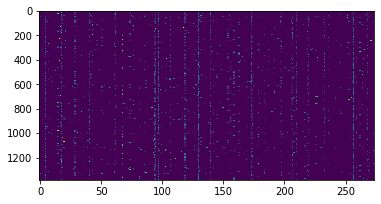

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(tfidf_chords.values, interpolation='nearest')
ax.set_aspect(0.1)

## TF-IDF for chord ngrams

In [11]:
# Using TF-IDF Transformer
tt = TfidfTransformer(norm='l2', use_idf=True)
tt_matrix = tt.fit_transform(bv_matrix)

tt_matrix = tt_matrix.toarray()
vocab = bv.get_feature_names()

tfidf_ngrams = pd.DataFrame(tt_matrix, columns=vocab)
tfidf_ngrams

,A Am FM7,A B7 EaugM7,A Bb B,A Bb Bbm,A C#m7 Cdim7,A Cdim7 Bm7,A Cm6 G,A D G,A E6 Bm7,A E6 E7,A E7 A,A F C#,A F G,A F#aug B7,A F#m7 Bm7,A G C#,A G F,A G# E,A11sus A13 DM7,A11sus A7 D11sus,A11sus A7 D13,A11sus A7 D7,A11sus A7 D9,A11sus A7 DM7,A11sus A7 Dm7,A11sus A7 F#m7,A11sus A7 FM7,A11sus Aaug7 Dm7,A11sus Bb11sus CM7,A11sus C11sus F11sus,A11sus DM7 C11sus,A11sus DM7 Dm7,A11sus DM7 G11sus,A11sus Dm7 C#m7,A11sus Dm7 D7,A11sus Dm7 G13,A11sus E11sus E9,A11sus G#11sus Dm7,A11sus G#m9 Em7,A11sus G6 A11sus,...,Gm7b5 F#m7 B7,Gm7b5 Fm7 Ebsus4,Gm9 Am9 Fm9,Gm9 Bbm9 Em9,Gm9 C13 FM7,Gm9 C6 Bm7b5,Gm9 C7 Bm7b5,Gm9 C7 DM7,Gm9 C7 F6,Gm9 C7 FM7,Gm9 C7 Gm9,Gm9 C9 FM7,Gm9 Caug7 Cm7,Gm9 Caug7 FM9,Gm9 Cdim7 FM7,Gm9 Cm9 Fm9,Gm9 Dm7 G7,Gm9 Em11 FM7,Gm9 F#7 FM7,Gm9 F9 Eaug7,Gm9 FM7 Am7,Gm9 Gm7 EbM7,Gm9 Gm7 Em7b5,GmM7 A7 Dm7,GmM7 AmM7 Gm7,GmM7 AmM7 GmM7,GmM7 F7 Baug7,GmM7 Gm7 GmM7,GmM7 Gm9 Dm7,Gmdim Dm7 G7,Gmdim G Gaug,Gsus4 Am7 Am9,Gsus4 C Bb,Gsus4 CM7 Dm7b5,Gsus4 Em7 Am7,Gsus4 G CM7,Gsus4 G G7,Gsus4 G7 C,Gsus4 G7 CM7,Gsus4 G7 Em7
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1381,0.0,0.0,0.0,0.0,0.0,0.0,0.

## Calculate the Cosinus Similarity to compare tunes

Get a list of tune pairs to compare and calculate the cosinus similarity for each pair.



In [12]:
# threshold for the cosinus similarity value to display
COS_THRES = 0.5

Helper function to display the result:

In [13]:
def get_similar_tunes(df, threshold = 0.9):
  # display tunes that have a cos_sim value bigger than the threshold

  # create a series of tunes containing a list of similar tunes for each tune
  cols = df.columns
  bt = df.apply(lambda x: x > threshold)
  result = bt.apply(lambda x: list(cols[x.values]), axis=1)

  # print the result
  tuneA = []
  tuneB = []
  cos_val = []

  for idx, val in result.iteritems():
    # if the tune is similar to other tunes
    if len(val) <= 1:
      continue
    #print(f'{idx}')
    for tune in val:
      if tune != idx:
        #print(f'\t{df.loc[idx][tune]:.3f} - {tune}')
        tuneA.append(idx)
        tuneB.append(tune)
        cos_val.append(df.loc[idx][tune])

  df_result = pd.DataFrame(list(zip(tuneA,
                                    tuneB,
                                    cos_val)),
                           columns=['tuneA', 'tuneB', 'cos_val']
                           )
  df_result.sort_values(['tuneA', 'cos_val'], ascending=[True, False], inplace=True)
  return df_result

### Using the single Chords


In [14]:
df_cos = pd.DataFrame(cosine_similarity(tfidf_chords),
                      columns=tune_names,
                      index=tune_names)

df_cos

,'S Wonderful,'Tis Autumn,26-2,500 Miles High,502 Blues,52nd Street Theme,9.20 Special,A Ballad,A Beautiful Friendship,A Blossom Fell,A Certain Smile,A Child Is Born,A Felicidade,A Fine Romance,A Flower Is A Lovesome Thing,A Foggy Day,A Ghost Of A Chance,A Kiss To Build A Dream On,A Little Tear,A Lovely Way To Spend An Evening,A Night In Tunisia,A Nightingale Sang In Berkeley Square,A Pretty Girl Is Like A Melody,A Sleepin' Bee,A Smooth One,A Sound For Sore Ears,A Sunday Kind Of Love,A Taste Of Honey,A Time For Love,A Tisket A Tasket,A Weaver Of Dreams,A Wonderful Day Like Today,Ablution,Ac-Cent-Tchu-Ate The Positive,Across The Alley From The Alamo,Adam's Apple,Affirmation,"African Queen, The",Afro Blue,Afro Centric,...,Wouldn't It Be Loverly,Wow,Wrap Your Troubles In Dreams,Yardbird Suite,Yes And No,Yes Sir That's My Baby,"Yes Sir, That's My Baby",Yesterday's Gardenias,Yesterdays,You And The Night And The Music,You Are Too Beautiful,You Better Go Now,You Better Leave it Alone,You Brought A New Kind Of Love,You Can Depend On Me,You Do Something To Me,You Don't Know What Love Is,You Go To My Head,You Keep Coming Back Like A Song,You Made Me Love You,You Make Me Feel So Young,You Must Believe In Spring,You Stepped Out Of A Dream,You Took Advantage Of Me,You Turned The Tables on Me,You Won't Forget Me,You'd Be So Nice To Come Home To,You're Blas�,You're Everything,You're Laughing At Me,You're My Everything,You're My Thrill,You're Nobody Till Somebody Loves You,You're The Top,You've Changed,Young And Foolish,Young At Heart,Zing Went The Strings Of My Heart,Zingaro (Retrato Em Branco E Preto),Zoltan
'S Wonderful,1.000000,0.181951,0.138595,0.039784,0.090015,0.641575,0.018699,0.397559,0.166126,0.289433,0.300104,0.086424,0.209780,0.212886,0.078637,0.203229,0.209062,0.132013,0.035744,0.180323,0.028784,0.280712,0.341641,0.099725,0.027147,0.000000,0.177907,0.044211,0.126423,0.210508,0.158689,0.226214,0.144001,0.105727,0.158966,0.067459,0.026617,0.001959,0.000000,0.048950,...,0.165686,0.121984,0.223955,0.272809,0.016613,0.022700,0.586724,0.114902,0.034898,0.027745,0.243439,0.265491,0.000000,0.240134,0.123654,0.298723,0.090234,0.263190,0.152408,0.620931,0.181188,0.084069,0.141966,0.285607,0.321419,0.154354,0.042046,0.122724,0.058057,0.140025,0.272926,0.054796,0.253103,0.293913,0.157731,0.156431,0.259925,0.234197,0.030309,0.000000
'Tis Autumn,0.181951,1.000000,0.294059,0.182254,0.156768,0.298473,0.022946,0.214321,0.627278,0.356684,0.579730,0.211697,0.712932,0.423999,0.308957,0.576707,0.526266,0.278126,0.115728,0.807822,0.177842,0.423883,0.399881,0.299522,0.144811,0.117072,0.601667,0.344670,0.535900,0.432222,0.675946,0.587155,0.359720,0.281807,0.479331,0.278871,0.282111,0.178421,0.114471,0.199686,...,0.428731,0.324360,0.513015,0.465265,0.265863,0.090829,0.105591,0.252539,0.154749,0.176667,0.751152,0.410735,0.018170,0.629090,0.265830,0.481086,0.303106,0.338970,0.496841,0.387375,0.478272,0.185972,0.386364,0.623133,0.477293,0.076205,0.479972,0.287020,0.176695,0.298700,0.568609,0.139081,0.511726,0.458756,0.316997,0.646492,0.548372,0.686222,0.261123,0.090013
26-2,0.138595,0.294059,1.000000,0.098648,0.151342,0.110817,0.021919,0.149986,0.245904,0.140280,0.367042,0.105603,0.343858,0.163958,0.189119,0.296274,0.285049,0.167438,0.114809,0.402076,0.052216,0.408857,0.209070,0.228399,0.048996,0.237959,0.285667,0.065732,0.211805,0.280029,0.356504,0.287805,0.466092,0.173689,0.337268,0.206969,0.213135,0.003284,0.078467,0.185882,...,0.132927,0.148733,0.338556,0.197838,0.486623,0.087685,0.061696,0.270431,0.085324,0.064708,0.310478,0.198549,0.017886,0.350423,0.098414,0.190757,0.216659,0.344343,0.322357,0.133811,0.252328,0.176729,0.553543,0.308258,0.233256,0.088513,0.213126,0.110151,0.188638,0.211182,0.356171,0.096307,0.205704,0.258879,0.299349,0.318704,0.181186,0.318422,0.192064,0.221357
500 Miles High,0.039784,0.182254,0.098648,1.000000,0.385910,0.076813,0.007254,0.219449,0.208644,0.041420,0.143785,0.068062,0.282408,0.082887,0.324191,0.061134,0.276689,0.200874

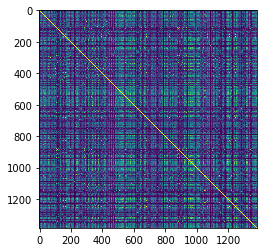

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(df_cos.values, interpolation='nearest')
ax.set_aspect(1)

In [16]:
df_result_chords = get_similar_tunes(df_cos, 
                                     threshold=COS_THRES)
df_result_chords

,tuneA,tuneB,cos_val
3,'S Wonderful,Always (I'll Be Loving You),0.789740
9,'S Wonderful,"Charleston, The",0.731825
1,'S Wonderful,All Alone,0.711090
46,'S Wonderful,Rose Of The Rio Grande,0.691623
47,'S Wonderful,Sheik Of Araby,0.684181
...,...,...,...
220538,Zoltan,Inner Urge,0.557308
220536,Zoltan,Early Autumn,0.530506
220539,Zoltan,Jaco,0.503068
220543,Zoltan,Spring Can Really Hang You Up The Most,0.502562


In [17]:
df_result_chords.query('tuneA == "Stars Fell On Alabama"')

,tuneA,tuneB,cos_val
178236,Stars Fell On Alabama,In Love In Vain,0.895913
178467,Stars Fell On Alabama,Valse Hot,0.893363
178505,Stars Fell On Alabama,You're Nobody Till Somebody Loves You,0.892348
178055,Stars Fell On Alabama,Billy Boy,0.888858
178299,Stars Fell On Alabama,Mambo Inn,0.886810
...,...,...,...
178070,Stars Fell On Alabama,Bright Mississippi,0.504963
178202,Stars Fell On Alabama,I Want To Talk About You,0.503899
178312,Stars Fell On Alabama,Moon Rays,0.501955
178346,Stars Fell On Alabama,Only Trust Your Heart,0.501316


### Using ngrams

In [18]:
df_cos = pd.DataFrame(cosine_similarity(tfidf_ngrams),
                      columns=tune_names,
                      index=tune_names)

df_cos

,'S Wonderful,'Tis Autumn,26-2,500 Miles High,502 Blues,52nd Street Theme,9.20 Special,A Ballad,A Beautiful Friendship,A Blossom Fell,A Certain Smile,A Child Is Born,A Felicidade,A Fine Romance,A Flower Is A Lovesome Thing,A Foggy Day,A Ghost Of A Chance,A Kiss To Build A Dream On,A Little Tear,A Lovely Way To Spend An Evening,A Night In Tunisia,A Nightingale Sang In Berkeley Square,A Pretty Girl Is Like A Melody,A Sleepin' Bee,A Smooth One,A Sound For Sore Ears,A Sunday Kind Of Love,A Taste Of Honey,A Time For Love,A Tisket A Tasket,A Weaver Of Dreams,A Wonderful Day Like Today,Ablution,Ac-Cent-Tchu-Ate The Positive,Across The Alley From The Alamo,Adam's Apple,Affirmation,"African Queen, The",Afro Blue,Afro Centric,...,Wouldn't It Be Loverly,Wow,Wrap Your Troubles In Dreams,Yardbird Suite,Yes And No,Yes Sir That's My Baby,"Yes Sir, That's My Baby",Yesterday's Gardenias,Yesterdays,You And The Night And The Music,You Are Too Beautiful,You Better Go Now,You Better Leave it Alone,You Brought A New Kind Of Love,You Can Depend On Me,You Do Something To Me,You Don't Know What Love Is,You Go To My Head,You Keep Coming Back Like A Song,You Made Me Love You,You Make Me Feel So Young,You Must Believe In Spring,You Stepped Out Of A Dream,You Took Advantage Of Me,You Turned The Tables on Me,You Won't Forget Me,You'd Be So Nice To Come Home To,You're Blas�,You're Everything,You're Laughing At Me,You're My Everything,You're My Thrill,You're Nobody Till Somebody Loves You,You're The Top,You've Changed,Young And Foolish,Young At Heart,Zing Went The Strings Of My Heart,Zingaro (Retrato Em Branco E Preto),Zoltan
'S Wonderful,1.000000,0.005852,0.000000,0.000000,0.000000,0.145905,0.0,0.065806,0.028940,0.066794,0.048421,0.000000,0.037685,0.039248,0.012332,0.027552,0.016812,0.000000,0.0,0.000000,0.000000,0.000000,0.003149,0.003577,0.00000,0.000000,0.007085,0.000000,0.000000,0.026375,0.017957,0.021613,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.027587,0.038696,0.000000,0.0,0.025353,0.005125,0.0,0.000000,0.045706,0.054666,0.0,0.013436,0.000000,0.028268,0.000000,0.013355,0.000000,0.134371,0.011460,0.002627,0.011538,0.025656,0.020814,0.0,0.000000,0.005915,0.000000,0.0,0.046415,0.0,0.017592,0.020156,0.005830,0.003091,0.035384,0.000000,0.0,0.0
'Tis Autumn,0.005852,1.000000,0.024166,0.000000,0.010108,0.000000,0.0,0.008799,0.035048,0.008122,0.037104,0.006476,0.084867,0.020438,0.021631,0.024322,0.051628,0.021040,0.0,0.119186,0.000000,0.008696,0.009394,0.000000,0.00815,0.012493,0.155206,0.043407,0.066664,0.020197,0.054771,0.031153,0.015617,0.008706,0.038103,0.0,0.008653,0.0,0.0,0.0,...,0.032607,0.032132,0.008453,0.030088,0.010670,0.0,0.000000,0.058314,0.0,0.000000,0.138135,0.005594,0.0,0.036750,0.023610,0.018531,0.013626,0.014402,0.014005,0.009574,0.015812,0.015059,0.043391,0.039069,0.078395,0.0,0.052386,0.012135,0.007277,0.0,0.072666,0.0,0.025527,0.013571,0.012774,0.055435,0.080316,0.051895,0.0,0.0
26-2,0.000000,0.024166,1.000000,0.000000,0.000000,0.000000,0.0,0.004427,0.037195,0.000000,0.025031,0.000000,0.029723,0.000000,0.000000,0.047204,0.005284,0.008439,0.0,0.074567,0.000000,0.016586,0.005622,0.000000,0.00000,0.013575,0.014670,0.000000,0.016044,0.010161,0.032507,0.010867,0.013584,0.003478,0.018846,0.0,0.009402,0.0,0.0,0.0,...,0.000000,0.008931,0.000000,0.002922,0.151923,0.0,0.000000,0.000000,0.0,0.000000,0.058521,0.014558,0.0,0.003025,0.000000,0.002838,0.004275,0.098849,0.019421,0.003468,0.006622,0.007086,0.021903,0.042340,0.042239,0.0,0.015742,0.002279,0.013536,0.0,0.023127,0.0,0.003650,0.025417,0.035829,0.055981,0.000000,0.016961,0.0,0.0
500 Miles High,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.016163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012070,0.000000,0.0,0.000000,0.008737,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000

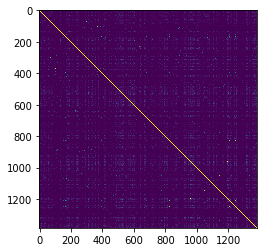

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(df_cos.values, interpolation='nearest')
ax.set_aspect(1)

In [20]:
df_result_ngrams = get_similar_tunes(df_cos, 
                                     threshold=0.5)
df_result_ngrams

,tuneA,tuneB,cos_val
0,52nd Street Theme,Heart And Soul,0.508421
1,A Weaver Of Dreams,There Will Never Be Another You,0.566322
2,Afro Blue,Lonnie's Lament,0.583989
3,Afro Blue,Midnight Blue,0.557229
8,Afternoon In Paris,Ornithology,0.557768
...,...,...,...
815,When The Saints Go Marching In,Deed I Do (Dixieland Tunes),0.606558
816,When The Saints Go Marching In,Jumpin' At The Woodside,0.531681
817,When You're Smilin',Perdido,0.554312
818,"Yes Sir, That's My Baby",Jumpin' At The Woodside,0.679189


In [21]:
df_result_ngrams.query('tuneA == "Stars Fell On Alabama"')

,tuneA,tuneB,cos_val
678,Stars Fell On Alabama,Mambo Inn,0.550570
679,Stars Fell On Alabama,Valse Hot,0.529014
677,Stars Fell On Alabama,Little Peace In C For You,0.502418
